# **Создание модели рекомендательной системы (версия 2)**

**Задача**

В группе компаний Тинькофф есть команда edTech, создающая платформу для обучающих курсов.
У команды edTech возникает вопрос, а какие курсы сильнее всего влияют на рабочие показатели сотрудников в колл-центре.
Помогите составить рекомендации, какие обучающие курсы стоит проходить сотрудникам, а какие курсы стоит убрать с edTech платформы.
Решение может быть как рекомендательной моделью для каждого из сотрудников, так и основано на бизнес-правилах и статистическом анализе (например, выделить для каждого департамента полезные курсы).

**Потенциальное решение**

Предполагается, что решение будет выполнено на Python, будет итоговая презентация. Решение может содержать блоки: эксплораторный анализ, Causal Inference методы, рекомендательную модель.
Ограничений на подход к решению нет, но для определения важности курсов советуем использовать методы анализа причинности. Подробнее можно почитать о них [здесь,](https://koch-kir.medium.com/causal-inference-from-observational-data-%D0%B8%D0%BB%D0%B8-%D0%BA%D0%B0%D0%BA-%D0%BF%D1%80%D0%BE%D0%B2%D0%B5%D1%81%D1%82%D0%B8-%D0%B0-%D0%B2-%D1%82%D0%B5%D1%81%D1%82-%D0%B1%D0%B5%D0%B7-%D0%B0-%D0%B2-%D1%82%D0%B5%D1%81%D1%82%D0%B0-afb84f2579f2) а также возможна консультация со стороны организаторов.

# **Описание таблиц**

**employees**

Информация о сотрудниках колл-центра
Поля:
- employee_id - идентификатор сотрудника
- sex – пол
- region - идентификатор федерального округа
- age – возраст
- head_employee_id – идентификатор руководителя
- exp_days – опыт в днях
- edu_degree – уровень образования
- department_id – индентификатор департамента, в котором работает сотрудник
- work_online_flg – флаг работы на удалённом режиме

**communications**

Информация о рабочих показателях сотрудников. Рассматривались рабочие коммункации операторов колл-центра
Поля:
- communication_id – идентификатор коммуникации
- communication_dt – дата коммуникации
- employee_id - идентификатор сотрудника
- communication_score – оценка качества коммуникации
- util_flg – флаг того, что клиент воспользовался банковским продуктом в течение 2 недель

**courses_passing**

Статиситка прохождения обучающих курсов сотрудниками
- course_id – идентификатор курса
- employee_id - идентификатор сотрудника
- pass_frac – доля прохождения курса
- start_dt – дата начала прохождения
- last_activity_dt – последняя активность сотрудника в обучающем курсе
- end_dt – дата окончания обучения. Если обучение пройдено не полностью, то NaN
- educ_duration_days – длительность полного обучения в днях. Если обучение пройдено не полностью, то NaN

**courses_info**

Информация о курсах
- course_id – идентификатор курса
- course_nm – название курса

**course_employee_sms**

Сводная таблица с нотификациями сотрудникам с предложением пройти обучение. Нотификации рассылались случайным образом
Поля:
- employee_id - идентификатор сотрудника
- course_i – флаг наличия нотификации

In [ ]:
# импортируем необходимые библиотеки
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.utils import resample

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import LabelEncoder

import warnings

In [ ]:
warnings.filterwarnings('ignore')

In [ ]:
# Установка опции для отображения нормальных чисел
pd.set_option('display.float_format', lambda x: '%.2f' % x)

## Объединие таблиц в один датасет

Решили оставить создание итогового датасета, так как его загрузка и сохранение занмиает значительное количество времени. 
Сохраним все этапы создания `full_data.csv`.

Загризим все датасеты

In [ ]:
# Загрузим датасет
communications = pd.read_csv('../data/src/communications.csv', sep=';', dtype={'employee_id': 'category'})
courses_passing = pd.read_csv('../data/src/courses_passing.csv', sep=';',  dtype={'employee_id': 'category'})
employees = pd.read_csv('../data/src/employees.csv', sep=';', dtype={'employee_id': 'category', 'head_employee_id': 'category', 'sex': 'category'})
course_employee_sms = pd.read_csv('../data/src/course_employee_sms.csv', sep=';')
courses_info = pd.read_csv('../data/src/courses_info.csv', sep=';')

In [ ]:
# Преобразование даты в datetime, если это необходимо
communications['communication_dt'] = pd.to_datetime(communications['communication_dt'])
courses_passing['end_dt'] = pd.to_datetime(courses_passing['end_dt'])

# Преобразование employee_id в строковый тип в обеих таблицах
communications['employee_id'] = communications['employee_id'].astype(str)
courses_passing['employee_id'] = courses_passing['employee_id'].astype(str)

# Сортировка данных перед объединением
communications_sorted = communications.sort_values(by='communication_dt')
courses_passing_sorted = courses_passing[courses_passing['end_dt'].notna()].sort_values(by='end_dt')

In [ ]:
# Оптимизированное объединение с использованием merge_asof
merged_data = pd.merge_asof(
    communications_sorted,
    courses_passing_sorted,
    by='employee_id',
    left_on='communication_dt',
    right_on='end_dt',
    direction='backward'  # Используем ближайшее значение end_dt, которое не позже communication_dt
)

In [ ]:
# Создание флагов для каждого курса
for i in range(92):  # Предполагаем, что курсы нумеруются от 0 до 91
    merged_data[f'course_{i}'] = np.where(merged_data['course_id'] == i, 1, np.nan)

In [ ]:
# Применение ffill для каждого курса по каждому сотруднику
for i in range(92):
    merged_data[f'course_{i}'] = merged_data.groupby('employee_id')[f'course_{i}'].ffill()

In [ ]:
# Очистка от временных и ненужных столбцов
final_data = merged_data.drop(columns=['course_id', 'pass_frac', 'start_dt', 'last_activity_dt', 'educ_duration_days'])

In [ ]:
# Сохранение исходного порядка строк
final_data = final_data.sort_index()

In [ ]:
# Рассмотрим первые строки
final_data.head()

,communication_id,communication_dt,employee_id,communication_score,util_flg,end_dt,course_0,course_1,course_2,course_3,...,course_82,course_83,course_84,course_85,course_86,course_87,course_88,course_89,course_90,course_91
0,265773861079506507,2023-01-01,cf2226dd-d41b-1a2d-0ae5-1dab54d32c36,0,0,NaT,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,278568857626326381,2023-01-01,7f5d04d1-89df-b634-e6a8-5bb9d9adf21e,68,1,NaT,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,466811215985540640,2023-01-01,04ecb1fa-2850-6ccb-6f72-b12c0245ddbc,0,0,NaT,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,187483347234781892,2023-01-01,af3303f8-52ab-eccd-7930-68486a391626,100,0,NaT,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,47065300189886434,2023-01-01,16026d60-ff9b-5441-0b34-35b403afd226,0,1,NaT,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Посмотрим информацию
final_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5345246 entries, 0 to 5345245
Data columns (total 98 columns):
 #   Column               Dtype         
---  ------               -----         
 0   communication_id     int64         
 1   communication_dt     datetime64[ns]
 2   employee_id          object        
 3   communication_score  int64         
 4   util_flg             int64         
 5   end_dt               datetime64[ns]
 6   course_0             float64       
 7   course_1             float64       
 8   course_2             float64       
 9   course_3             float64       
 10  course_4             float64       
 11  course_5             float64       
 12  course_6             float64       
 13  course_7             float64       
 14  course_8             float64       
 15  course_9             float64       
 16  course_10            float64       
 17  course_11            float64       
 18  course_12            float64       
 19  course_13            

Начнем с объединения таблиц `employees` и `final_data`. В качестве ключа используем `employee_id` 

In [ ]:
# Объединение данных
full_data = pd.merge(employees, final_data, on='employee_id', how='inner')

## Обработка полученного датасета

Обработаем пропуски в датасете `full_data`

In [ ]:
# Заполнение NaN нулями для всех курсовых столбцов
for i in range(92):  # курсы нумеруются от 0 до 91
    column_name = f'course_{i}'
    full_data[column_name] = full_data[column_name].fillna(0)

Теперь проверим нормализацию дат

In [ ]:
# Убедимся, что все столбцы с датами имеют тип datetime
date_columns = ['communication_dt', 'end_dt']
for col in date_columns:
    full_data[col] = pd.to_datetime(full_data[col], errors='coerce')  # Преобразование в datetime, невалидные значения станут NaT

In [ ]:
# Проверка результатов
print(full_data[date_columns].info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5345246 entries, 0 to 5345245
Data columns (total 2 columns):
 #   Column            Dtype         
---  ------            -----         
 0   communication_dt  datetime64[ns]
 1   end_dt            datetime64[ns]
dtypes: datetime64[ns](2)
memory usage: 81.6 MB
None


Отсортируем по дате и удалим пропуски по столбцу `course_id`

In [ ]:
# Отсортируем данные
full_data_sorted = full_data.sort_values(by=['communication_dt'])

In [ ]:
# Установка параметра отображения всех строк
pd.set_option('display.max_rows', None)

In [ ]:
# Посмотрим количество пропусков
display(full_data_sorted.isna().sum())

employee_id                  0
sex                          0
region                       0
age                          0
head_employee_id             0
exp_days                     0
edu_degree                   0
department_id                0
work_online_flg              0
communication_id             0
communication_dt             0
communication_score          0
util_flg                     0
end_dt                 2347714
course_0                     0
course_1                     0
course_2                     0
course_3                     0
course_4                     0
course_5                     0
course_6                     0
course_7                     0
course_8                     0
course_9                     0
course_10                    0
course_11                    0
course_12                    0
course_13                    0
course_14                    0
course_15                    0
course_16                    0
course_17                    0
course_1

Обработаем пропуски еще в столбце `end_dt` заполнив их текущей датой

In [20]:
# Сбросим индексы после сортировки
full_data_sorted = full_data_sorted.reset_index(drop=True)

In [21]:
# Важно убедиться, что это логично для вашей задачи
current_date = pd.Timestamp('today')

# Если end_dt должно указывать на продолжающееся обучение, можно использовать текущую дату
full_data_sorted['end_dt'].fillna(current_date, inplace=True)

# Вывод количества пропущенных значений после обработки
display(full_data_sorted.isna().sum())

employee_id            0
sex                    0
region                 0
age                    0
head_employee_id       0
exp_days               0
edu_degree             0
department_id          0
work_online_flg        0
communication_id       0
communication_dt       0
communication_score    0
util_flg               0
end_dt                 0
course_0               0
course_1               0
course_2               0
course_3               0
course_4               0
course_5               0
course_6               0
course_7               0
course_8               0
course_9               0
course_10              0
course_11              0
course_12              0
course_13              0
course_14              0
course_15              0
course_16              0
course_17              0
course_18              0
course_19              0
course_20              0
course_21              0
course_22              0
course_23              0
course_24              0
course_25              0


Видим что теперь пропусков теперь нет.

Теперь разделим датасет на два периода и закодируем столбцы `employee_id`, `course_id`

In [22]:
# Проверка порядка индекса
if full_data_sorted.index.is_monotonic_increasing:
    print("Временной ряд идет по возрастанию.")
elif full_data_sorted.index.is_monotonic_decreasing:
    print("Временной ряд идет по убыванию.")
else:
    print("Временной ряд не отсортирован.")

Временной ряд идет по возрастанию.


In [23]:
# Создание временных признаков
full_data_sorted['time_since_end'] = (full_data_sorted['communication_dt'] - full_data_sorted['end_dt']).dt.days.fillna(0)

In [24]:
# Предлагаю считать оценку разговора по следующей формуле
full_data_sorted['weighted_mark'] = \
    full_data_sorted['util_flg'] * 100 * 0.5 \
    + full_data_sorted['communication_score'] * 0.5
# Так мы учтём влияние прихода клиента в общей оценке,
# как немаловажный показатель эффективности труда.

In [25]:
# Установим опцию отображения максимального количества столбцов
pd.set_option('display.max_columns', None)

In [26]:
# Посмотрим количество пропусков
full_data_sorted.head()

,employee_id,sex,region,age,head_employee_id,exp_days,edu_degree,department_id,work_online_flg,communication_id,communication_dt,communication_score,util_flg,end_dt,course_0,course_1,course_2,course_3,course_4,course_5,course_6,course_7,course_8,course_9,course_10,course_11,course_12,course_13,course_14,course_15,course_16,course_17,course_18,course_19,course_20,course_21,course_22,course_23,course_24,course_25,course_26,course_27,course_28,course_29,course_30,course_31,course_32,course_33,course_34,course_35,course_36,course_37,course_38,course_39,course_40,course_41,course_42,course_43,course_44,course_45,course_46,course_47,course_48,course_49,course_50,course_51,course_52,course_53,course_54,course_55,course_56,course_57,course_58,course_59,course_60,course_61,course_62,course_63,course_64,course_65,course_66,course_67,course_68,course_69,course_70,course_71,course_72,course_73,course_74,course_75,course_76,course_77,course_78,course_79,course_80,course_81,course_82,course_83,course_84,course_85,course_86,course_87,course_88,course_89,course_90,course_91,time_since_end,weighted_mark
0,f57a2f55-7b09-8c43-f11a-b969efe1504b,M,6,25,c74d97b0-1eae-257e-44aa-9d5bade97baf,904,2,1,0,219306075423967632,2023-01-01,79,0,2024-04-19 23:19:44.121742,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-475,39.50
1,d095a94d-20dc-af7a-a073-01948549bede,F,0,31,e2ef524f-bf3d-9fe6-11d5-a8e90fefdc9c,411,0,2,0,802974500810989106,2023-01-01,65,1,2024-04-19 23:19:44.121742,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-475,82.50
2,4e0928de-0755-38c5-93fb-dabb0c5ef2c3,M,5,47,9bf31c7f-f062-936a-96d3-c8bd1f8f2ff3,875,2,1,0,751355936482620181,2023-01-01,85,1,2024-04-19 23:19:44.121742,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-475,92.50
3,4e0928de-0755-38c5-93fb-dabb0c5ef2c3,M,5,47,9bf31c7f-f062-936a-96d3-c8bd1f8f2ff3,875,2,1,0,727306582578442688,2023-01-01,100,0,2024-04-19 23:19:44.121742,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-475,50.00
4,4e0928de-0755-38c5-93fb-dabb0c5ef2c3,M,5,47,9bf31c7f-f062-936a-96d3-c8bd1f8f2ff3,875,2,1,0,955703013403990253,2023-01-01,67,1,2024-04-19 23:19:44.121742,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0

In [27]:
full_data_sorted.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5345246 entries, 0 to 5345245
Columns: 108 entries, employee_id to weighted_mark
dtypes: category(2), datetime64[ns](2), float64(93), int64(10), object(1)
memory usage: 4.2+ GB


In [28]:
# Определение точки разделения (например, 80% данных для обучения)
split_index = int(len(full_data_sorted) * 0.8)

# Создание тренировочного и тестового наборов
train_data = full_data_sorted.iloc[:split_index]
test_data = full_data_sorted.iloc[split_index:]

train_data = train_data.drop(columns=['communication_score', 'util_flg'])
test_data = test_data.drop(columns=['communication_score', 'util_flg'])

In [29]:
train_data.head()

,employee_id,sex,region,age,head_employee_id,exp_days,edu_degree,department_id,work_online_flg,communication_id,communication_dt,end_dt,course_0,course_1,course_2,course_3,course_4,course_5,course_6,course_7,course_8,course_9,course_10,course_11,course_12,course_13,course_14,course_15,course_16,course_17,course_18,course_19,course_20,course_21,course_22,course_23,course_24,course_25,course_26,course_27,course_28,course_29,course_30,course_31,course_32,course_33,course_34,course_35,course_36,course_37,course_38,course_39,course_40,course_41,course_42,course_43,course_44,course_45,course_46,course_47,course_48,course_49,course_50,course_51,course_52,course_53,course_54,course_55,course_56,course_57,course_58,course_59,course_60,course_61,course_62,course_63,course_64,course_65,course_66,course_67,course_68,course_69,course_70,course_71,course_72,course_73,course_74,course_75,course_76,course_77,course_78,course_79,course_80,course_81,course_82,course_83,course_84,course_85,course_86,course_87,course_88,course_89,course_90,course_91,time_since_end,weighted_mark
0,f57a2f55-7b09-8c43-f11a-b969efe1504b,M,6,25,c74d97b0-1eae-257e-44aa-9d5bade97baf,904,2,1,0,219306075423967632,2023-01-01,2024-04-19 23:19:44.121742,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-475,39.50
1,d095a94d-20dc-af7a-a073-01948549bede,F,0,31,e2ef524f-bf3d-9fe6-11d5-a8e90fefdc9c,411,0,2,0,802974500810989106,2023-01-01,2024-04-19 23:19:44.121742,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-475,82.50
2,4e0928de-0755-38c5-93fb-dabb0c5ef2c3,M,5,47,9bf31c7f-f062-936a-96d3-c8bd1f8f2ff3,875,2,1,0,751355936482620181,2023-01-01,2024-04-19 23:19:44.121742,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-475,92.50
3,4e0928de-0755-38c5-93fb-dabb0c5ef2c3,M,5,47,9bf31c7f-f062-936a-96d3-c8bd1f8f2ff3,875,2,1,0,727306582578442688,2023-01-01,2024-04-19 23:19:44.121742,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-475,50.00
4,4e0928de-0755-38c5-93fb-dabb0c5ef2c3,M,5,47,9bf31c7f-f062-936a-96d3-c8bd1f8f2ff3,875,2,1,0,955703013403990253,2023-01-01,2024-04-19 23:19:44.121742,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0

In [30]:
# Создание экземпляра LabelEncoder
user_encoder = LabelEncoder()
item_encoder = LabelEncoder()

# Кодирование пользовательских и курсовых ID в непрерывные целочисленные значения
train_data['encoded_employee_id'] = user_encoder.fit_transform(train_data['employee_id'])

# Повторите эти шаги для тестовых данных, используя те же кодировщики (fit не нужен)
test_data['encoded_employee_id'] = user_encoder.transform(test_data['employee_id'])

In [36]:
full_data_sorted['encoded_employee_id'] = user_encoder.transform(full_data_sorted['employee_id'])

## Создание модели с коллаборативной фильтрацией

Для коллаборативной фильтрации можно использовать оценки сотрудников, например, `communication_score` и учет прохождения курсов, чтобы рекомендовать курсы, которые проходили сотрудники с похожими рабочими результатами. Попробуем обучить модель с помощью GPU  с помощью PyTorch:

In [31]:
class CFData(Dataset):
    def __init__(self, dataframe):
        """
        Конструктор класса CFData.
        
        Args:
            dataframe (DataFrame): Входной DataFrame с данными.
        """
        # Кодировка employee_id и course_id должна быть уже выполнена в dataframe
        self.users = torch.tensor(dataframe['encoded_employee_id'].values, dtype=torch.int64)
        
        # Для курсов создаем матрицу, где строки соответствуют пользователям, а столбцы - курсам
        # Для примера, используем первые 92 курса. Можно изменить, если у вас другое количество курсов.
        course_columns = [f'course_{i}' for i in range(92)]
        self.courses = torch.tensor(dataframe[course_columns].values, dtype=torch.float32)
        
        # Используем новую метрику weighted_mark
        self.ratings = torch.tensor(dataframe['weighted_mark'].values, dtype=torch.float32)

    def __len__(self):
        """
        Возвращает общее количество элементов в наборе данных.
        
        Returns:
            int: Общее количество элементов.
        """
        return len(self.ratings)

    def __getitem__(self, idx):
        """
        Получает элементы из набора данных по заданному индексу.
        
        Args:
            idx (int): Индекс элемента.
        
        Returns:
            tuple: Кортеж, содержащий данные о пользователе, курсах и рейтинге.
        """
        # Получаем данные о пользователе, курсах и рейтинге по заданному индексу
        return self.users[idx], self.courses[idx], self.ratings[idx]

In [32]:
# Создание экземпляра PyTorch Dataset для обучающих данных
train_dataset = CFData(train_data)

# Создание DataLoader для обучающего набора данных
# batch_size - количество элементов в одном батче
# shuffle - указывает, следует ли перемешивать данные перед каждой эпохой
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)

In [33]:
# Определение модели SVD (Singular Value Decomposition)
class SVDModel(nn.Module):
    def __init__(self, n_users, n_courses, n_factors=100):
        """
        Args:
            n_users (int): Количество пользователей.
            n_courses (int): Количество курсов.
            n_factors (int): Количество скрытых факторов для пользователей.
        """
        super(SVDModel, self).__init__()
        self.user_factors = nn.Embedding(n_users, n_factors)
        self.course_layer = nn.Linear(n_courses, n_factors)

    def forward(self, user, courses):
        user_embedding = self.user_factors(user)
        course_vector = self.course_layer(courses)
        # Произведение поэлементное, затем суммируем по второй оси
        dot_product = (user_embedding * course_vector).sum(1)
        return dot_product

In [37]:
# Инициализация модели
n_users = full_data_sorted['encoded_employee_id'].nunique()
n_courses = 92 
model = SVDModel(n_users, n_courses).to('cuda')

In [38]:
# Определение оптимизатора и функции потерь
optimizer = optim.Adam(model.parameters(), lr=0.01)  # Оптимизатор Adam с коэффициентом скорости обучения 0.01
criterion = nn.MSELoss()  # Функция потерь Mean Squared Error (MSE)

In [41]:
model.train()  # Установка модели в режим обучения
for epoch in range(10):
    for users, courses, ratings in train_loader:
        users, courses, ratings = users.to('cuda'), courses.to('cuda'), ratings.to('cuda')  # Перенос данных на GPU
        optimizer.zero_grad()  # Обнуление градиентов
        outputs = model(users, courses)  # Получение выходных данных модели
        loss = criterion(outputs, ratings)  # Вычисление потерь
        loss.backward()  # Обратное распространение ошибки
        optimizer.step()  # Обновление параметров модели
    print(f'Epoch {epoch+1}, Loss: {loss.item()}') 

Epoch 1, Loss: 1077.71484375
Epoch 2, Loss: 1070.86865234375
Epoch 3, Loss: 1155.5604248046875
Epoch 4, Loss: 1164.125244140625
Epoch 5, Loss: 1076.9398193359375
Epoch 6, Loss: 1132.3685302734375
Epoch 7, Loss: 1077.27099609375
Epoch 8, Loss: 1053.695556640625
Epoch 9, Loss: 1023.1920776367188
Epoch 10, Loss: 1170.080810546875


In [42]:
# Сохранение модели
torch.save(model, '..\models\model_v2.pth')

In [50]:
# Загрузка модели
#model = torch.load('..\models\model_v2.pth')
#model.eval()

In [44]:
# Перевод модели в режим оценки
model.eval()

# Список для хранения предсказаний
predictions = []

with torch.no_grad():  # Выключение расчета градиентов для ускорения
    for users, courses, _ in predict_loader:
        users, courses = users.to('cuda'), courses.to('cuda')
        outputs = model(users, courses)
        predictions.extend(outputs.cpu().numpy())  # Перемещение предсказаний на CPU и преобразование в numpy array

# Сохранение предсказаний обратно в DataFrame
test_data['predicted_score'] = predictions

In [48]:
test_data.head()

,employee_id,sex,region,age,head_employee_id,exp_days,edu_degree,department_id,work_online_flg,communication_id,communication_dt,end_dt,course_0,course_1,course_2,course_3,course_4,course_5,course_6,course_7,course_8,course_9,course_10,course_11,course_12,course_13,course_14,course_15,course_16,course_17,course_18,course_19,course_20,course_21,course_22,course_23,course_24,course_25,course_26,course_27,course_28,course_29,course_30,course_31,course_32,course_33,course_34,course_35,course_36,course_37,course_38,course_39,course_40,course_41,course_42,course_43,course_44,course_45,course_46,course_47,course_48,course_49,course_50,course_51,course_52,course_53,course_54,course_55,course_56,course_57,course_58,course_59,course_60,course_61,course_62,course_63,course_64,course_65,course_66,course_67,course_68,course_69,course_70,course_71,course_72,course_73,course_74,course_75,course_76,course_77,course_78,course_79,course_80,course_81,course_82,course_83,course_84,course_85,course_86,course_87,course_88,course_89,course_90,course_91,time_since_end,weighted_mark,encoded_employee_id,predicted_score
4276196,98b29795-0041-a424-7026-9d56260243a1,F,0,32,a97da629-b098-b75c-294d-ffdc3e463904,462,0,2,1,208683383608586016,2023-10-05,2024-04-19 23:19:44.121742,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-198,86.50,1412,63.54
4276197,98b29795-0041-a424-7026-9d56260243a1,F,0,32,a97da629-b098-b75c-294d-ffdc3e463904,462,0,2,1,348977980212807976,2023-10-05,2024-04-19 23:19:44.121742,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-198,93.50,1412,63.54
4276198,1a0a283b-fe7c-549d-ee6c-638a05200e32,F,0,31,9bf31c7f-f062-936a-96d3-c8bd1f8f2ff3,144,1,1,0,504806389015696605,2023-10-05,2024-04-19 23:19:44.121742,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-198,87.00,274,65.14
4276199,98b29795-0041-a424-7026-9d56260243a1,F,0,32,a97da629-b098-b75c-294d-ffdc3e463904,462,0,2,1,550077828171691044,2023-10-05,2024-04-19 23:19:44.121742,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-198,86.50,1412,63.54
4276200,98b29795-0041-a424-7026-9d56260243a1,F,0,32,a97da629-b098-b75c-294d-ffdc3e463904,462,0,2,1,652728150588480707,2023-10-05,2024-04-19 23:19:44.121742,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.

In [59]:
# Предполагая, что test_data уже содержит столбцы 'employee_id' и 'course_id'
# Добавляем столбец с предсказаниями
test_data['predicted_score'] = predictions

# Удаляем дубликаты, если они есть
test_data.drop_duplicates(subset=['employee_id', 'course_id'], inplace=True)

# Сортировка данных по предсказанной оценке в убывающем порядке
sorted_recommendations = test_data.sort_values(by=['employee_id', 'predicted_score'], ascending=[True, False])

# Выбираем топ-5 курсов для каждого сотрудника
top_courses_per_employee = sorted_recommendations.groupby('employee_id').head(5)

# Если у вас есть DataFrame с информацией о курсах, названия которых нужно отобразить
courses_info = pd.DataFrame({
    'course_id': range(n_courses),
    'course_nm': ['Название курса {}'.format(i) for i in range(n_courses)]
})

# Объединение с информацией о курсах для отображения названий
top_courses_per_employee = top_courses_per_employee.merge(courses_info, on='course_id', how='left')

# Вывод рекомендаций
print(top_courses_per_employee[['employee_id', 'course_id', 'course_nm', 'predicted_score']].head(20))

KeyError: Index(['course_id'], dtype='object')

In [57]:
# Преобразование данных о курсах из широкого формата в длинный
courses_columns = [f'course_{i}' for i in range(92)]  # Предполагаем, что у вас 92 курса
melted_courses = test_data.melt(id_vars=['employee_id', 'predicted_score'], 
                                value_vars=courses_columns, 
                                var_name='course_id', 
                                value_name='course_taken')

In [53]:
melted_courses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98352600 entries, 0 to 98352599
Data columns (total 4 columns):
 #   Column           Dtype  
---  ------           -----  
 0   employee_id      object 
 1   predicted_score  float32
 2   course_id        object 
 3   course_taken     float64
dtypes: float32(1), float64(1), object(2)
memory usage: 2.6+ GB


In [58]:
# Преобразуем столбец 'course_id' в melted_courses к типу int, избавляясь от префикса 'course_'
melted_courses['course_id'] = melted_courses['course_id'].str.replace('course_', '').astype(int)

# Преобразуем 'course_id' в courses_info к типу int, если он еще не int
courses_info['course_id'] = courses_info['course_id'].astype(int)

# Теперь объединяем, так как типы данных совпадают
final_recommendations = melted_courses.merge(courses_info, on='course_id', how='left')

# Удаляем все предыдущие дубликаты, основываясь на employee_id и course_id
final_recommendations.drop_duplicates(subset=['employee_id', 'course_id'], inplace=True)

# Сортировка по предсказанному рейтингу и выбор топ-5 уникальных курсов для каждого сотрудника
top_n_recommendations = final_recommendations.sort_values(by=['employee_id', 'predicted_score'], ascending=[True, False])
top_n_recommendations = top_n_recommendations.groupby('employee_id').head(5)

# Показ результатов
top_n_recommendations[['employee_id', 'course_id', 'course_nm', 'predicted_score']].head(30)

,employee_id,course_id,course_nm,predicted_score
4617,0004d0b5-9e19-461f-f126-e3a08a814c33,0,Основы клиентского сервиса: Практический подход,64.25
1073667,0004d0b5-9e19-461f-f126-e3a08a814c33,1,Эффективное взаимодействие с клиентами: Техник...,64.25
2142717,0004d0b5-9e19-461f-f126-e3a08a814c33,2,Мастерство общения с клиентами: Практические н...,64.25
3211767,0004d0b5-9e19-461f-f126-e3a08a814c33,3,Улучшение качества обслуживания клиентов: Осно...,64.25
4280817,0004d0b5-9e19-461f-f126-e3a08a814c33,4,Искусство управления жалобами и конфликтами с ...,64.25
46383,00411460-f7c9-2d21-24a6-7ea0f4cb5f85,0,Основы клиентского сервиса: Практический подход,75.64
1115433,00411460-f7c9-2d21-24a6-7ea0f4cb5f85,1,Эффективное взаимодействие с клиентами: Техник...,75.64
2184483,00411460-f7c9-2d21-24a6-7ea0f4cb5f85,2,Мастерство общения с клиентами: Практические н...,75.64
3253533,00411460-f7c9-2d21-24a6-7ea0f4cb5f85,3,Улучшение качества обслуживания клиентов: Осно...,75.64
4322583,00411460-f7c9-2d21-24a6-7ea0f4cb5f85,4,Искусство управления жалобами и конфликтами с ...,75.64


In [89]:
# Сохраним данные
top_n_recommendations.to_csv('top_n_recommendations.csv')

## Анализ полученных результатов

Проанализируем полученные результаты следующим образом:
1. **Анализ Распределения Оценок** - это поможет нам увидеть, как распределены предсказанные оценки среди рекомендованных курсов. Мы можем построить гистограмму, чтобы визуализировать это распределение.
2. **Анализ Частоты Рекомендаций Курсов**. Мы можем проверить, какие курсы рекомендуются чаще всего. Это поможет выявить, есть ли курсы, которые чрезмерно предпочтительны моделью.

In [95]:
# Загрузим датасет
recommendations_df = pd.read_csv('top_n_recommendations.csv')

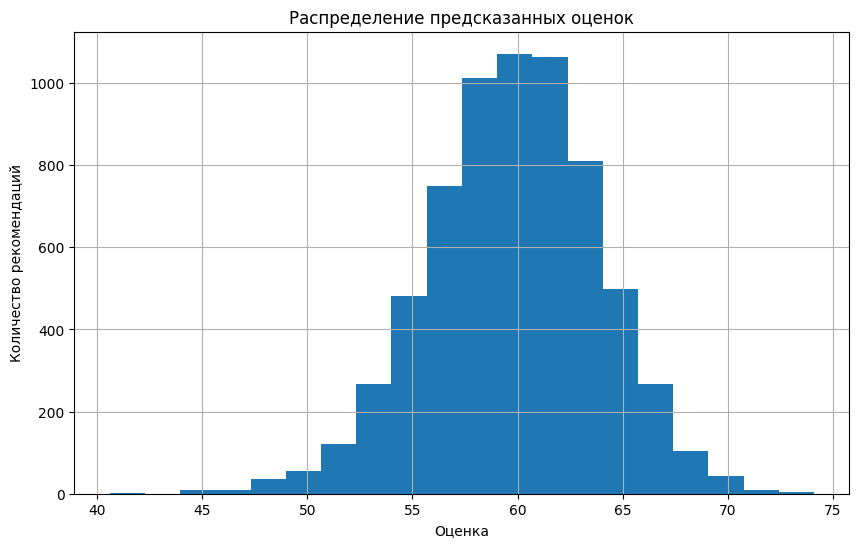

In [97]:
# Анализ распределения оценок
plt.figure(figsize=(10, 6))
recommendations_df['predicted_score'].hist(bins=20)
plt.title('Распределение предсказанных оценок')
plt.xlabel('Оценка')
plt.ylabel('Количество рекомендаций')
plt.show()

По графику:
- Нормальное распределение: Оценки приближаются к нормальному распределению, сосредотачиваясь вокруг среднего значения. Это может указывать на то, что модель дает умеренные предсказания без чрезмерных крайностей в оценках. Данный график вообще не похож на распределение в разведовательном анализе, где было два пика по краям.
- Центр тяжести: Большинство предсказанных оценок сконцентрированы в диапазоне примерно от 50 до 70, что может свидетельствовать о том, что модель в целом не склонна к выдаче крайне высоких или низких оценок.
- Пик распределения: Пиковые значения гистограммы, кажется, находятся в районе 55-65, что предполагает наиболее часто предсказываемую оценку моделью.
- Отсутствие крайних значений: На графике видно, что мало оценок выше 70 и ниже 40, что может свидетельствовать о некотором сжатии предсказаний (отсутствие большой вариабельности).

In [106]:
# Находим топ рекомендацию для каждого сотрудника
top_recommendations_by_employee = recommendations_df.loc[recommendations_df.groupby('employee_id')['predicted_score'].idxmax()]

# Подсчет частоты встречаемости каждого курса среди топ рекомендаций
top_course_counts = top_recommendations_by_employee[['course_id','course_nm']].value_counts()

# Вывод топ-10 курсов
print("Топ-20 наиболее высоко оцененных курсов:")
print(top_course_counts.head(20))

Топ-20 наиболее высоко оцененных курсов:
course_id  course_nm                                                                 
45.00      Развитие коммуникативных навыков в клиентском обслуживании                    95
84.00      Управление клиентским опытом: Интеграция процессов и технологий               89
34.00      Создание эффективных обучающих материалов для клиентов                        82
20.00      Основы психологии клиентского обслуживания                                    78
43.00      Управление ожиданиями и эмоциями клиентов в условиях кризиса                  63
7.00       Построение долгосрочных отношений с клиентами: Техники и методы               63
10.00      Использование технологий в клиентском обслуживании: Лучшие практики           62
88.00      Создание индивидуальных планов обслуживания для ключевых клиентов             55
39.00      Развитие навыков активного прослушивания в клиентском сервисе                 45
1.00       Эффективное взаимодействие с клиен

**Выводы:**

- Соответствие с анализом важности курсов: В топе рекомендаций есть курсы, соответствующие самым важным направлениям, упомянутым в анализе: 
    - Коммуникативные навыки и этика: Курсы, такие как "Развитие коммуникативных навыков в клиентском обслуживании" и "Этика и профессиональное поведение в клиентском обслуживании", находятся в топе рекомендаций, что соответствует акценту на важность этих навыков в анализе.

- Профессиональное поведение и управление клиентским опытом: Курсы по управлению клиентским опытом и кризисам также присутствуют в списке, что отражает стремление улучшить взаимодействие с клиентами и управление ожиданиями.

- Тренды и новые технологии: Темы, связанные с интеграцией процессов и технологий, например, "Управление клиентским опытом: Интеграция процессов и технологий", выделяются в рекомендациях, что указывает на важность адаптации к новым трендам и технологиям в сфере обслуживания клиентов.

- Разнообразие предложений: Список топ-20 рекомендаций включает разнообразные темы, что может свидетельствовать о попытке модели обеспечить комплексный подход к обучению сотрудников, покрывающий широкий спектр компетенций.

- Недостаток персонализации: Наличие повторяющихся курсов для разных сотрудников может указывать на недостаток персонализации в рекомендациях. Это может быть связано с моделью, которая склонна предпочитать определенные курсы независимо от индивидуальных характеристик сотрудников.


В дальнейшем возможно лучше сосредоточиться на двух направлениях:
- Повышение точности предсказания рекомендаций

- Персонализация: надо попробовать поискать способы улучшения персонализации модели, чтобы удостовериться, что рекомендации соответствуют индивидуальным потребностям и интересам каждого сотрудника.

- Баланс тем: возможно надо стремиться к балансу между фундаментальными навыками и новыми технологиями, чтобы обеспечить сотрудникам комплексное и актуальное образование.